# Tutorial for spatial multi-omics vertical integration using DIRAC

- by CHANG XU changxu@nus.edu.sg.
- Last update: October 4th 2024

## Installation
- Make sure ``sodirac`` is installed via ``pip install sodirac``.
- The Python environment needs to install the packages listed in ``requirements.txt``.

In [1]:
########## load packages
import os 
import random

import pandas as pd 
import numpy as np 
import torch
import scanpy as sc
import matplotlib.pyplot as plt

######## load dirac
import sodirac as sd

2024-10-07 12:26:42.619665: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 12:26:44.578123: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 12:26:44.831249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 12:26:45.405536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 12:26:45.594850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 12:26:46.700173: I tensorflow/core/platform/cpu_feature_gu

[easydl] tensorflow not available!


## Download the data
- if you are have ``wget`` installed, you can run the following code to automatically download and unzip the data.

In [ ]:
# Skip this cells if data are already download
! wget -O 0725_Protein.h5ad "https://drive.google.com/uc?export=download&id=1en6bitR0ROS6eh-RgNJECErVVAzLMiok"
! wget -O 0725_RNA.h5ad "https://drive.google.com/uc?export=download&id=1uclBRs1I4Q1Yvq0eUfZbBwPiOVgFaKMt"

- if you do not have wget installed, manually download data from the links below:
    - DBiT-seq collected from ADT: https://drive.google.com/file/d/1en6bitR0ROS6eh-RgNJECErVVAzLMiok/view?usp=drive_link.
    - DBiT-seq collected from Protein: https://drive.google.com/file/d/1uclBRs1I4Q1Yvq0eUfZbBwPiOVgFaKMt/view?usp=drive_link.

In [2]:
def seed_torch(seed=1029):   
    random.seed(seed)    
    os.environ['PYTHONHASHSEED'] = str(seed)    
    np.random.seed(seed)    
    torch.manual_seed(seed)    
    torch.cuda.manual_seed(seed)    
    torch.cuda.manual_seed_all(seed) 
    # if you are using multi-GPU.    
    torch.backends.cudnn.benchmark = False    
    torch.backends.cudnn.deterministic = True

seed_torch(seed=0)

In [3]:
######### Define colors for spatial multi-omics domain
colormaps= ["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#A65628", "#FFFF33", "#F781BF", "#999999", 
            "#E5D8BD", "#B3CDE3", "#CCEBC5", "#FED9A6", "#FBB4AE", "#8DD3C7", "#BEBADA", "#80B1D3", "#B3DE69", "#FCCDE5", 
            "#BC80BD", "#FFED6F", "#8DA0CB", "#E78AC3", "#E5C494", "#CCCCCC", "#FB9A99", "#E31A1C", "#CAB2D6","#6A3D9A", "#B15928"]

## Load DBiT-seq data
- Here, DBiT-seq contains 936 spots, in each of which there are 22,802 genes and 22 proteins measured.

In [4]:
data_path = "/home/project/11003054/changxu/Data/DBiT_seq"
data_name = "0725"
methods = "DIRAC"

In [5]:
adata_RNA = sc.read(os.path.join(data_path, f"{data_name}_RNA.h5ad"))
adata_Protein = sc.read(os.path.join(data_path, f"{data_name}_Protein.h5ad"))
adata_RNA.raw = adata_RNA
adata_Protein.raw = adata_Protein

In [6]:
adata_Protein[adata_RNA.obs_names]

View of AnnData object with n_obs × n_vars = 936 × 22
    obs: 'x', 'y', 'ground_truth'
    obsm: 'spatial'

## Prepare to Integrate

- Following the workflow of single-cell preprocessing, we performed data cleaning and preparation. To accelerate model training, we applied PCA for dimensionality reduction.
- We offer multiple methods for constructing spatial neighborhood graphs, including "knn," "KDTree," and "Radius." Here, we chose the `KDTree` method and set the number of nearest neighbors to 8.
- For the parameter *k*, extensive experiments indicate that values between 6 and 15 yield optimal results. This selection is also dependent on the resolution of the omics data being processed; generally, higher resolution data benefits from a larger number of spatial neighbors.
- The `save_path` parameter should be specified. If not provided, the output will default to the current directory.

In [7]:
######### Data processing
n_clusters = len(adata_RNA.obs["ground_truth"].unique())
adata_RNA.obs["Omics"] = data_name + "_mRNA"
adata_RNA.obs['Omics'] = adata_RNA.obs['Omics'].astype('category')
adata_Protein.obs["Omics"] = data_name + "_Protein"
adata_Protein.obs['Omics'] = adata_Protein.obs['Omics'].astype('category')

In [8]:
######### Data processing
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)
sc.pp.highly_variable_genes(adata_RNA, n_top_genes=3000, subset=True, flavor='seurat_v3')
sc.pp.scale(adata_RNA)
sc.tl.pca(adata_RNA, n_comps=40)

In [9]:
sc.pp.normalize_total(adata_Protein)
sc.pp.log1p(adata_Protein)
sc.pp.scale(adata_Protein)

In [10]:
adj = graph(data = adata_RNA.obsm["spatial"],
	rad_cutoff = 1.5,
	k = 8,
	distType= "KDTree", ### "BallTree", "Radius", "kneighbors_graph",'KDTree'
	).main()["adj_norm"]

row, col, edge_attr = adj.t().coo()
edge_index = torch.stack([row, col], dim=0)

In [11]:
y = pd.Categorical(
    np.array(adata_RNA.obs["Omics"]),
    categories=np.unique(adata_RNA.obs["Omics"]),
    ).codes
save_path = os.path.join("/home/users/nus/changxu/scratch/section1/Results", f"{data_name}_{methods}")
if not os.path.exists(save_path):
    os.makedirs(save_path)

## Training DIRAC

In [12]:
###### Training Dirac for spatial multi-omics
dirac = sd.integrate_app(save_path = save_path, use_gpu = True, subgraph = False)
samples = dirac._get_data(dataset_list = [adata_RNA.obsm["X_pca"].copy(), adata_Protein.X.copy()],
	batch_list = [y, y],
	domain_list = [np.zeros(adata_RNA.shape[0]), np.ones(adata_Protein.shape[0])],
	edge_index = edge_index,
	num_parts = 10,
	num_workers = 1,)
models = dirac._get_model(samples, 
	n_hiddens = 128,
	n_outputs = 64,
	opt_GNN = "GCN",) 
data_z, combine_recon, now = dirac._train_dirac_integrate(samples = samples,
	models = models,
	epochs = 500,
	lamb = 5e-4, 
	scale_loss = 0.025,
	lr = 1e-3,
	wd = 5e-2,)

Found 2 unique domains.


Project..: 100%|█| 500/500 [00:12<00:00, 40.36it/s, Loss=73.3, D


In [13]:
adata_RNA.obsm[f"{methods}_embed"] = data_z[: adata_RNA.shape[0], :]
adata_Protein.obsm[f"{methods}_embed"] = data_z[adata_RNA.shape[0] :, :]
adata_RNA.obsm["combine_recon"] = combine_recon
adata_Protein.obsm["combine_recon"] = combine_recon

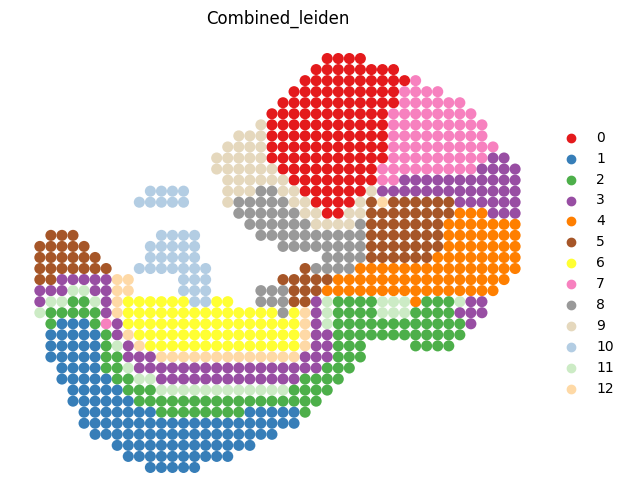

In [16]:
####### Combined
sc.pp.neighbors(adata_RNA, use_rep='combine_recon')
res_RNA_ATAC = _priori_cluster(adata_RNA, eval_cluster_n = n_clusters)
sc.tl.leiden(adata_RNA, resolution = res_RNA_ATAC, key_added="Combined_leiden")
# mclust_R(adata=adata_RNA, num_cluster = n_clusters, used_obsm="combine_recon",key_added="Combined_mclust")
# sc.pl.spatial(adata_RNA, color=["Combined_mclust", "Combined_leiden", "ground_truth"], palette = colormaps, frameon=False, spot_size=1)
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.spatial(adata_RNA, color=["Combined_leiden"], palette = colormaps, frameon=False, spot_size=1, ax=ax)
fig.savefig(os.path.join(save_path, f"{data_name}_{methods}_Combined_spatial_{now}.pdf"), bbox_inches='tight', dpi = 300)

## Save data

In [18]:
adata_RNA.write(os.path.join(save_path, f"{data_name}_{methods}_RNA_Final_{now}.h5ad"), compression="gzip")
adata_Protein.write(os.path.join(save_path, f"{data_name}_{methods}_Protein_Final_{now}.h5ad"), compression="gzip)